In [1]:
!pip install -q transformers datasets
!pip install evaluate
!pip install peft
!pip install accelerate -U
!pip install transformers[torch]
!pip install umap-learn
!pip install -U imbalanced-learn
!pip3 install Cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 37.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [2]:
import numpy as np
import pandas as pd

# Setup

In [3]:
MAX_LEN = 512
roberta_checkpoint = "roberta-large"
mistral_checkpoint = "mistralai/Mistral-7B-v0.1"
llama_checkpoint = "NousResearch/Llama-2-7b-hf"

In [4]:
filename = "https://media.githubusercontent.com/media/Branden-Kang/LLaMA-2/main/data/final_preprocessed_df2.csv"

df = pd.read_csv(filename)

<ipython-input-4-8e1658895b12>:3: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [5]:
df_pre = df[['title_with_selftext_cleaned','class_group']]
df_pre.columns = ['text','label_str']

In [6]:
df_pre = df_pre.dropna(subset='label_str')

In [7]:
df_pre['label'] = df_pre.label_str.map({
    'Depression_Group': 0,
    'Neutral_Group': 1,
    'Happy_Group': 2,
})

In [8]:
df_pre = df_pre[['text','label']]

In [9]:
from sklearn.utils import resample

df_depression = df_pre[df_pre.label==0]
df_neutral = df_pre[df_pre.label==1]
df_happy = df_pre[df_pre.label==2]

df_depression_sampled = resample(df_depression, replace=True, n_samples=8000, random_state=42) # reproducible results
df_neutral_sampled = resample(df_neutral, replace=True, n_samples=8000, random_state=42) # reproducible results
df_happy_sampled = resample(df_happy, replace=True, n_samples=8000, random_state=42) # reproducible results

df_sampled = pd.concat([df_depression_sampled, df_neutral_sampled, df_happy_sampled])

In [10]:
df_train_dataset, df_validation_dataset, df_test_dataset = np.split(df_sampled.sample(frac=1), [int(.75*len(df_sampled)), int(.9*len(df_sampled))])

In [11]:
df_train_dataset.to_csv('train_dataset.csv', index=False)
df_validation_dataset.to_csv('validation_dataset.csv', index=False)
df_test_dataset.to_csv('test_dataset.csv', index=False)

In [12]:
from datasets import Features, Value, ClassLabel
from datasets import load_dataset

class_names = ["Depression_Group", "Neutral_Group", "Happy_Group"]
sentiment_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})
file_dict = {'train': 'train_dataset.csv',
             'validation':'validation_dataset.csv',
             'test': 'test_dataset.csv'}
dataset = load_dataset('csv', data_files=file_dict, delimiter=",", column_names=['text', 'label'], features=sentiment_features, skiprows=1)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [14]:
from datasets import Dataset
# Split the dataset into training and validation datasets
data = dataset['train'].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
data['val'] = data.pop("test")
# Convert the test dataframe to HuggingFace dataset and add it into the first dataset
data['test'] = dataset['test']

In [16]:
import pandas as pd

data['train'].to_pandas().info()
data['test'].to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14400 non-null  object
 1   label   14400 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 225.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2400 non-null   object
 1   label   2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [17]:
# Number of Characters
max_char = data['train'].to_pandas()['text'].str.len().max()
# Number of Words
max_words = data['train'].to_pandas()['text'].str.split().str.len().max()

In [18]:
data['train'][0]

{'text': 'realistic scenario  failed tech assessment miserably  task straightforward  need get data api  fiter return response  front end evolved  catch minute moment open challenge  already code editor  like login component logic  know kind stuff  took almost minute understand task code place  done filtering sample response  minute left left time finish api call time  would expect junior mid level developer able code thing minute ',
 'label': 1}

In [19]:
# Load Llama 2 Tokenizer
# Add prefix space to tokenize words into subwords
from transformers import AutoTokenizer, DataCollatorWithPadding
llama_tokenizer = AutoTokenizer.from_pretrained(llama_checkpoint,  add_prefix_space=True)
llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
llama_tokenizer.pad_token = llama_tokenizer.eos_token

def llama_preprocessing_function(examples):
    return llama_tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)
# col_to_delete = ['id', 'keyword','location', 'text']
llama_tokenized_datasets = data.map(llama_preprocessing_function, batched=False)
# llama_tokenized_datasets = llama_tokenized_datasets.remove_columns(col_to_delete)
# llama_tokenized_datasets = llama_tokenized_datasets.rename_column("target", "label")
llama_tokenized_datasets.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
llama_data_collator = DataCollatorWithPadding(tokenizer=llama_tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Map:   0%|          | 0/14400 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [20]:
from transformers import AutoModelForSequenceClassification # Load a pre-trained model with a sequence classification header
import torch
llama_model =  AutoModelForSequenceClassification.from_pretrained(
  pretrained_model_name_or_path=llama_checkpoint,
  num_labels=3,
  device_map="auto",
  offload_folder="offload",
  trust_remote_code=True
)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at NousResearch/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
llama_model.config.pad_token_id = llama_model.config.eos_token_id

In [22]:
from peft import get_peft_model, LoraConfig, TaskType
llama_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=16, lora_alpha=16, lora_dropout=0.05, bias="none",
    target_modules=[
        "q_proj",
        "v_proj",
    ],
)

llama_model = get_peft_model(llama_model, llama_peft_config)
llama_model.print_trainable_parameters()

trainable params: 8,400,896 || all params: 6,615,756,800 || trainable%: 0.12698314424133608


In [23]:
import evaluate
import numpy as np

def compute_metrics(eval_pred):
    # All metrics are already predefined in the HF `evaluate` package
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric= evaluate.load("f1")
    accuracy_metric = evaluate.load("accuracy")

    logits, labels = eval_pred # eval_pred is the tuple of predictions and labels returned by the model
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    # The trainer is expecting a dictionary where the keys are the metrics names and the values are the scores.
    return {"precision": precision, "recall": recall, "f1-score": f1, 'accuracy': accuracy}

In [24]:
from transformers import Trainer

class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss() # weight=torch.tensor([neg_weights, pos_weights], device=model.device, dtype=logits.dtype)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [25]:
from transformers import TrainingArguments, Trainer

llama_model = llama_model.cuda()

lr = 1e-4
batch_size = 8
num_epochs = 1
training_args = TrainingArguments(
    output_dir="llama-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # report_to="wandb",
    fp16=True,
    gradient_checkpointing=True,
)



llama_trainer = WeightedCELossTrainer(
    model=llama_model,
    args=training_args,
    train_dataset=llama_tokenized_datasets['train'],
    eval_dataset=llama_tokenized_datasets["val"],
    data_collator=llama_data_collator,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
llama_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
1,0.210700,0.212816,0.934022,0.932500,0.932232,0.932500


TrainOutput(global_step=1800, training_loss=0.27029920789930556, metrics={'train_runtime': 617.422, 'train_samples_per_second': 23.323, 'train_steps_per_second': 2.915, 'total_flos': 1.749787919548416e+17, 'train_loss': 0.27029920789930556, 'epoch': 1.0})

In [27]:
#eval
metrics = llama_trainer.evaluate(eval_dataset=llama_tokenized_datasets["val"])

In [28]:
metrics

{'eval_loss': 0.21281565725803375,
 'eval_precision': 0.9340219480413493,
 'eval_recall': 0.9325,
 'eval_f1-score': 0.9322316002069246,
 'eval_accuracy': 0.9325,
 'eval_runtime': 125.8729,
 'eval_samples_per_second': 28.6,
 'eval_steps_per_second': 3.575,
 'epoch': 1.0}

In [27]:
# # Save trained model and tokenizer
# llama_trainer.save_model()
# llama_tokenizer.save_pretrained("llama-lora-token-classification")

('llama-lora-token-classification/tokenizer_config.json',
 'llama-lora-token-classification/special_tokens_map.json',
 'llama-lora-token-classification/tokenizer.model',
 'llama-lora-token-classification/added_tokens.json',
 'llama-lora-token-classification/tokenizer.json')

In [28]:
# from peft import AutoPeftModelForSequenceClassification
# from transformers import AutoTokenizer

In [37]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def measure_model_performance(trainer, df_input, y_labels, labels_list):
    preds_output = trainer.predict(df_input)
    print(preds_output.metrics)
    y_preds = np.argmax(preds_output.predictions, axis=1)
    plot_confusion_matrix(y_preds, y_labels, labels_list)

In [38]:
labels_names_list = dataset['train'].features['label'].names

{'test_loss': 0.21281565725803375, 'test_precision': 0.9340219480413493, 'test_recall': 0.9325, 'test_f1-score': 0.9322316002069246, 'test_accuracy': 0.9325, 'test_runtime': 122.6197, 'test_samples_per_second': 29.359, 'test_steps_per_second': 3.67}


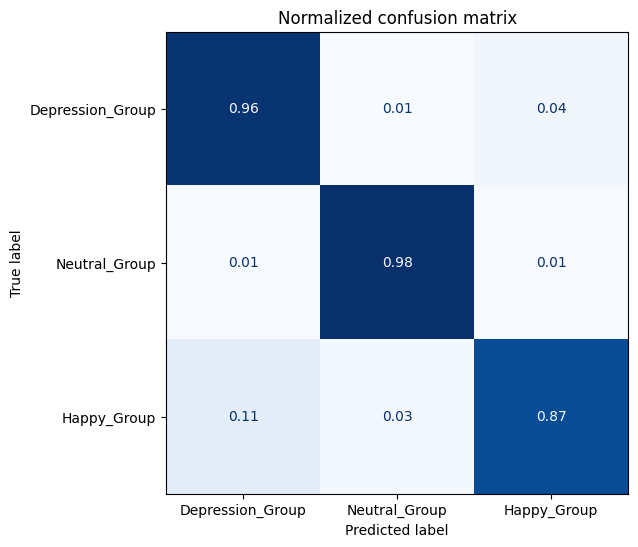

In [39]:
measure_model_performance(llama_trainer, llama_tokenized_datasets["val"], llama_tokenized_datasets["val"]['label'], labels_names_list)

{'test_loss': 0.22482691705226898, 'test_precision': 0.9282490726819085, 'test_recall': 0.9266666666666666, 'test_f1-score': 0.9258259960674426, 'test_accuracy': 0.9266666666666666, 'test_runtime': 81.0684, 'test_samples_per_second': 29.605, 'test_steps_per_second': 3.701}


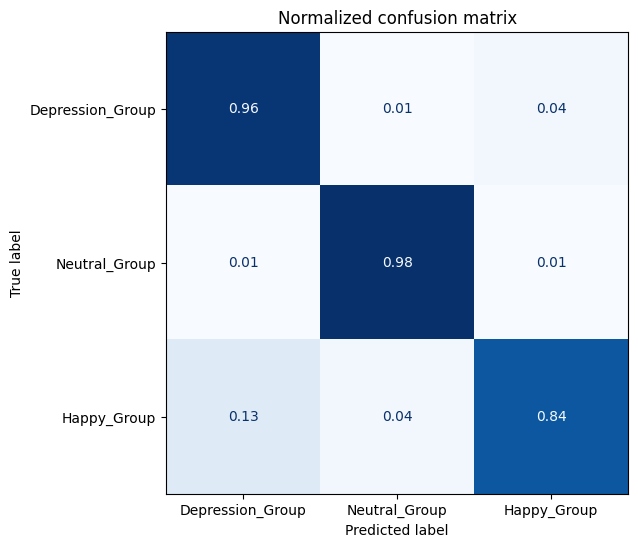

In [40]:
measure_model_performance(llama_trainer, llama_tokenized_datasets["test"], llama_tokenized_datasets["test"]['label'], labels_names_list)

In [ ]:
# # Save the model and tokenizer
# trainer.model.save_pretrained(new_model)
# trainer.tokenizer.save_pretrained(new_model)

In [41]:
from transformers import pipeline
classifier = pipeline("text-classification", model=llama_model.model, tokenizer=llama_tokenizer)
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [42]:
labels_names_list = dataset['train'].features['label'].names

In [43]:
from transformers import pipeline
classifier = pipeline("text-classification", model=llama_model.model, tokenizer=llama_tokenizer)
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
print(preds)

[[{'label': 'LABEL_0', 'score': 0.008946260437369347}, {'label': 'LABEL_1', 'score': 0.008155100047588348}, {'label': 'LABEL_2', 'score': 0.9828985929489136}]]


I saw a movie today and it was really good.


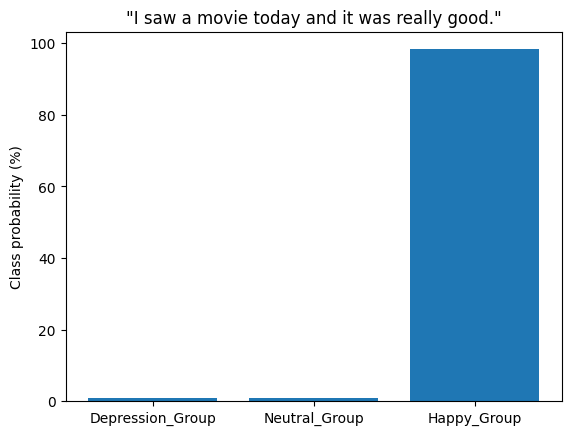

In [45]:
import matplotlib.pyplot as plt
preds_df = pd.DataFrame(preds[0])
print(custom_tweet)
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

I just surprised how Napolean Bonapart, such a great leader, portreyed as an such egoist person only follow personal wishes


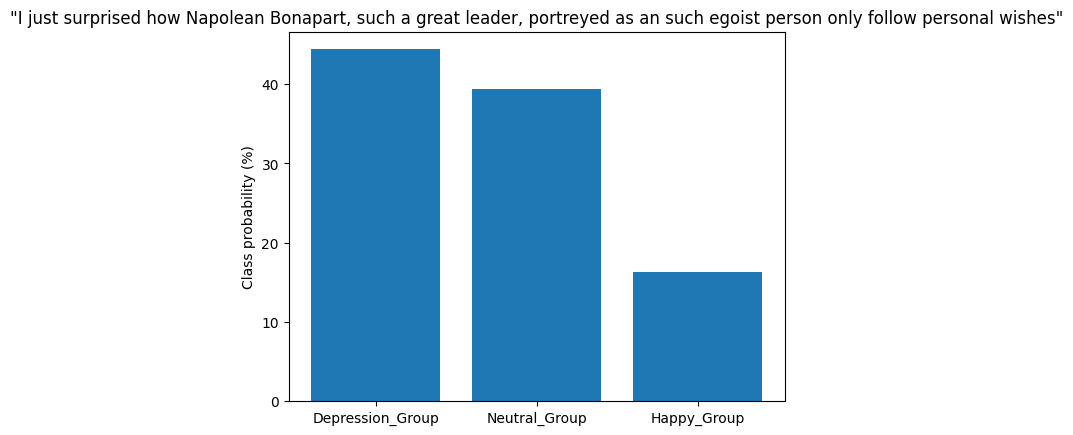

In [53]:
custom_tweet = "I just surprised how Napolean Bonapart, such a great leader, portreyed as an such egoist person only follow personal wishes"
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

Unfortunately, this film appears to have been designed more to mock Napoleon than anything else. Reducing him to a pathetic caricature does a great disservice to a complex individual and makes this films value as a biopic close to nil. The battles scenes are the only reason I'm giving this even two stars.


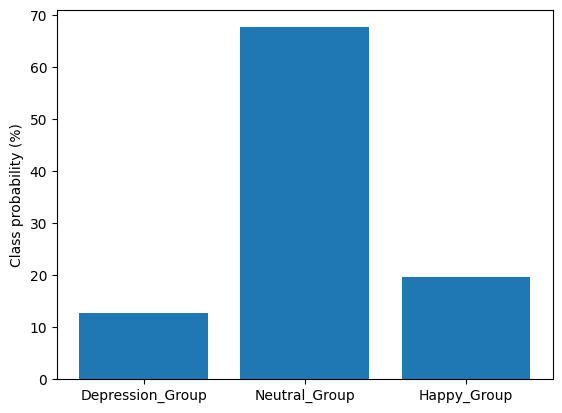

In [52]:
custom_tweet = "Unfortunately, this film appears to have been designed more to mock Napoleon than anything else. Reducing him to a pathetic caricature does a great disservice to a complex individual and makes this films value as a biopic close to nil. The battles scenes are the only reason I'm giving this even two stars."
print(custom_tweet)

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Saw it twice. What an amazing movie. Love it


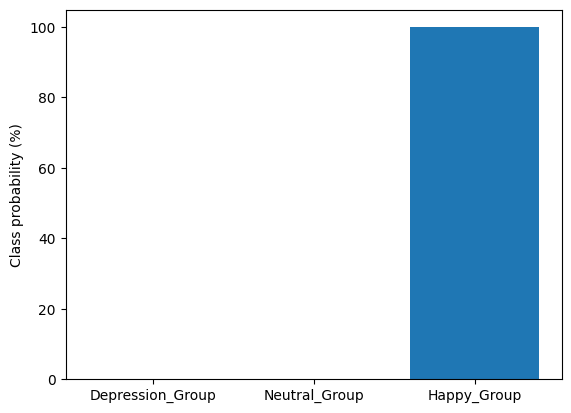

In [51]:
custom_tweet = "Saw it twice. What an amazing movie. Love it"
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

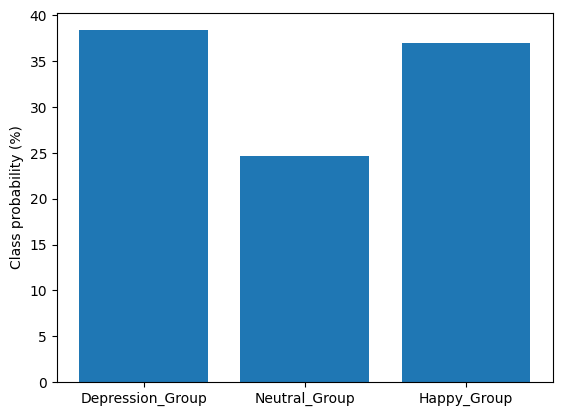

Visually stunning with some amazing battle scenes but it did have major pacing issues, especially in the first half. Also there was practically zero context given for like half the stuff that happened.


In [50]:
custom_tweet = "Visually stunning with some amazing battle scenes but it did have major pacing issues, especially in the first half. Also there was practically zero context given for like half the stuff that happened."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

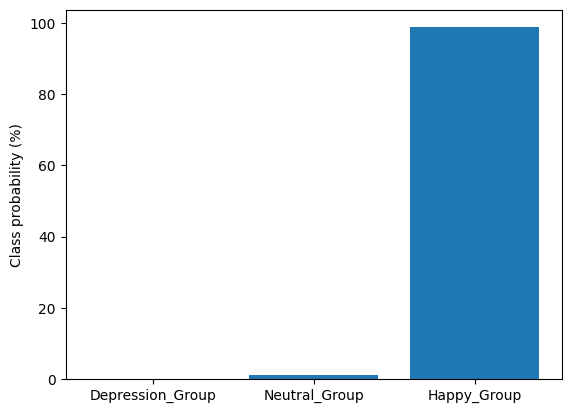

I am giving 2 stars out of 5


In [49]:
custom_tweet = "I am giving 2 stars out of 5"
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

I have failed my nlp exam and so sad and not want to do anything. Life sucks


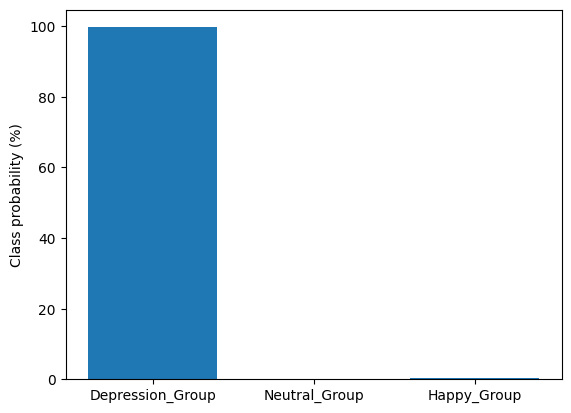

In [48]:
custom_tweet = "I have failed my nlp exam and so sad and not want to do anything. Life sucks"
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

At a recent workshop, researchers and journalists debated how to announce a potential discovery of extraterrestrial life


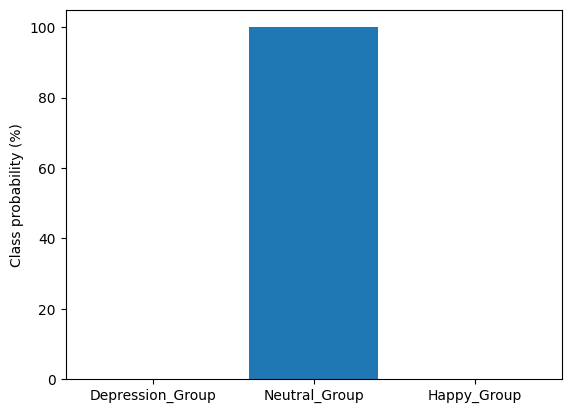

In [47]:
custom_tweet = "At a recent workshop, researchers and journalists debated how to announce a potential discovery of extraterrestrial life"
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

I failed my NLP exam yesterday and was really sad and didn't know what to do.I thought like life really sucks but today I met my best friend and he encouraged me and cheered me up to overcome this hardship. Because of his support I am not sad anymore and exam is just exam and it will be fine.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


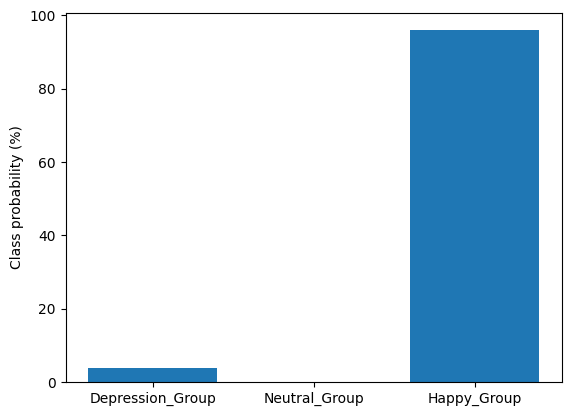

In [46]:
custom_tweet = custom_tweet = "I failed my NLP exam yesterday and was really sad and didn't know what to do.\
I thought like life really sucks but today I met my best friend and he encouraged me and cheered me up to overcome this hardship. \
Because of his support I am not sad anymore and exam is just exam and it will be fine."
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

This birthday, I wish you abundant happiness and love. May all your dreams turn into reality and may lady luck visit your home today.


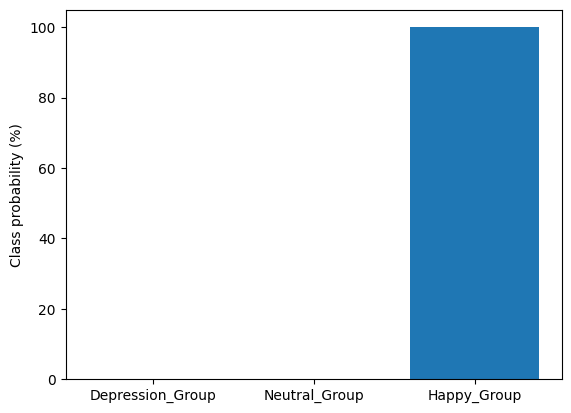

In [54]:
custom_tweet = "This birthday, I wish you abundant happiness and love. May all your dreams turn into reality and may lady luck visit your home today."
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

# Shap

In [55]:
!pip install nlp
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.7 MB/s eta 0:00:00


In [56]:
import nlp
import numpy as np
import scipy as sp
import torch
import transformers

import shap

In [57]:
# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            llama_tokenizer.encode(v, padding="max_length", max_length=512, truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = llama_model.model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val

In [59]:
# custom_tweet = "I have failed my nlp exam and so sad and not want to do anything. Life sucks"

# test = {'label': [0], 'text': [custom_tweet]}

# # build an explainer using a token masker
# explainer = shap.Explainer(f, llama_tokenizer)

# # explain the model's predictions on IMDB reviews
# # imdb_train = nlp.load_dataset("imdb")["train"]
# shap_values = explainer(test, fixed_context=1)

# # plot the first sentence's explanation
# shap.plots.text(shap_values)